In [11]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)
test_examples, test_labels = tfds.as_numpy(test_data)
test_df = pd.DataFrame({'review': test_examples, 'label': test_labels})

In [13]:
import re

def clean_review(review):
    if isinstance(review, bytes):
        review = review.decode('utf-8')
    if review.startswith("b'") or review.startswith('b"'):
        review = review[2:-1]
    review = re.sub(r"<br\s*/?>", " ", review)
    review = review.replace("\\n", " ").replace("\\'", "'").replace('\\"', '"')
    return review

test_df['clean_review'] = test_df['review'].apply(clean_review)


In [14]:
pd.set_option('display.max_colwidth', 300)
test_df[:4]

,review,label,clean_review
0,"b""There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforement...",1,"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementio..."
1,"b""A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss. As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money an...",1,"A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss. As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money and ..."
2,"b'Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay Movie. Making ""Superhero Movie"" the eleventh in a series that single handily ruined the parody genre. Now I\'ll admit it I have a soft spot for classics such as Airplane and The Naked Gun but you...",0,"Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay Movie. Making ""Superhero Movie"" the eleventh in a series that single handily ruined the parody genre. Now I'll admit it I have a soft spot for classics such as Airplane and The Naked Gun but you kn..."
3,"b'Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing ""feel-good"" movie, but she\'s trampled by the run-away sentimentality of a film that\'s not the least bit grounded in reality.<br /><br />This was directed by Curtis Hanson? Did he have a lobotomy since we las...",0,"Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing ""feel-good"" movie, but she's trampled by the run-away sentimentality of a film that's not the least bit grounded in reality. This was directed by Curtis Hanson? Did he have a lobotomy since we last heard from h..."


In [15]:
def create_strict_binary_prompt(review):
    return f"Is the sentiment of this review :'{review}'.positive or negative ? Respond with 'Positive' or 'Negative' only."


test_df['prompt'] = test_df['clean_review'].apply(create_strict_binary_prompt)

In [16]:
from concurrent.futures import ThreadPoolExecutor
from langchain_community.llms import Ollama
llm = Ollama(model="llama3.1:8b")

In [17]:
prompts = test_df['prompt'].tolist()

In [ ]:
def process_prompt ( prompt ):
   return llm.invoke ( prompt )

with ThreadPoolExecutor(max_workers=8) as executor:  
    results = list(executor.map(process_prompt, prompts[:10]))

test_df.loc[:9, 'predicted_sentiment'] = results
print(test_df.head(5))


In [ ]:
from sklearn.metrics import accuracy_score

predicted_sentiment_numeric = [1 if sentiment == 'Positive' else  0 for sentiment in results ]

accuracy = accuracy_score(test_df['label'][:250], predicted_sentiment_numeric)

print(f"Dokładność: {accuracy * 100:.2f}%")

In [1]:
from sklearn.metrics import accuracy_score

predicted_sentiment_numeric = [1 if sentiment == 'Positive' else  0 for sentiment in results ]

accuracy = accuracy_score(test_df['label'][:250], predicted_sentiment_numeric)

print(f"Dokładność: {accuracy * 100:.2f}%")


NameError: name 'results' is not defined

Precyzja: 0.90
Czułość: 0.88
F1-Score: 0.89


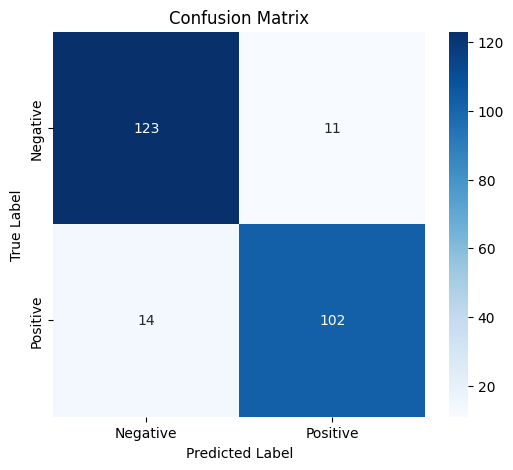

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Precyzja
precision = precision_score(test_df['label'][:250], predicted_sentiment_numeric)

# Czułość
recall = recall_score(test_df['label'][:250], predicted_sentiment_numeric)

# F1-Score
f1 = f1_score(test_df['label'][:250], predicted_sentiment_numeric)

print(f"Precyzja: {precision:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")




cm= confusion_matrix(test_df['label'][:250], predicted_sentiment_numeric)

# Wykres macierzy 
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
plot_confusion_matrix(cm)


In [ ]:
filtered_data = test_df[
    ((test_df['label'] == 1) & (test_df['predicted_sentiment'] == 'Negative')) |
    ((test_df['label'] == 0) & (test_df['predicted_sentiment'] == 'Positive'))
]
filtered_data

In [32]:


pd.set_option('display.max_colwidth', 300)
filtered_data = filtered_data.loc[[8], ['review', 'label', 'predicted_sentiment']]
filtered_data
filtered_data.style.set_properties(**{'white-space': 'pre-wrap'})

,review,label,predicted_sentiment
8,"b'As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you\'re in for a good time. Have a brew, butter up some large pretzels, and enjoy.Of course, obtaining a copy requires buying a bootleg or downloading it as shareware, but if you\'re here on the IMDb, then you\'re most likely savvy enough to do so. Good luck.And look for my favorite part....where Dr. Doom informs the FF that they have 12 hours to comply with his wishes....and he actually gestures the number ""12"" with his finger while doing so....it\'s like ""Evil Sesame Street""....hoo boy....and of course Mrs. Storm declaring ""Just look at you....the Fanstastic Four"" is just so heartwarming....you\'ll laugh, you\'ll cry.....So if you love schlocky Sci-Fi, this one\'s Fantastic For you!'",0,Positive


Model gpt-3.5-turbo

In [36]:
import os
from openai import OpenAI


client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")  
)

#Funkcja do przetwarzania promptów
def process_prompt(prompt):
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant specializing in sentiment analysis."},
                {"role": "user", "content": prompt}
            ],
            model="gpt-3.5-turbo",
        )
        # Zwracamy odpowiedź modelu
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error processing prompt: {e}")
        return "Error"
#Przetwarzanie
results = [process_prompt(prompt) for prompt in prompts[:2500]]
test_df.loc[:2499, 'predicted_sentiment'] = results

In [41]:
from sklearn.metrics import accuracy_score

predicted_sentiment_numeric = [1 if sentiment == 'Positive' else  0 for sentiment in results ]

accuracy = accuracy_score(test_df['label'][:2500], predicted_sentiment_numeric)

print(f"Dokładność: {accuracy * 100:.2f}%")

Dokładność: 93.80%


Precyzja: 0.94
Czułość: 0.94
F1-Score: 0.94


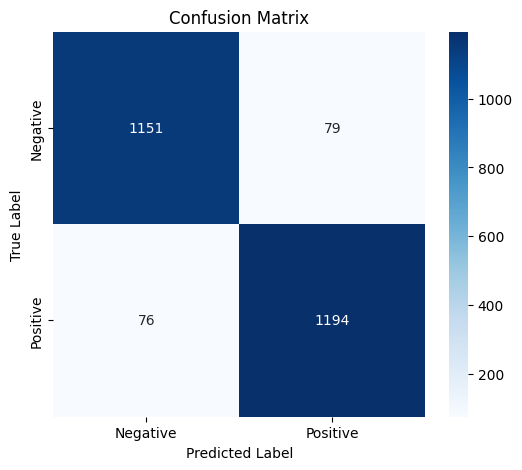

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Precyzja
precision = precision_score(test_df['label'][:2500], predicted_sentiment_numeric)
#Czułość
recall = recall_score(test_df['label'][:2500], predicted_sentiment_numeric)
#F1-Score
f1 = f1_score(test_df['label'][:2500], predicted_sentiment_numeric)

print(f"Precyzja: {precision:.2f}")
print(f"Czułość: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")




cm= confusion_matrix(test_df['label'][:2500], predicted_sentiment_numeric)

# Wykres macierzy 
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
plot_confusion_matrix(cm)


In [45]:
filtered_data = test_df[
    ((test_df['label'] == 1) & (test_df['predicted_sentiment'] == 'Negative')) |
    ((test_df['label'] == 0) & (test_df['predicted_sentiment'] == 'Positive'))
]
pd.set_option('display.max_colwidth', 300)
filtered_data = filtered_data.loc[[8], ['review', 'label', 'predicted_sentiment']]
filtered_data
filtered_data.style.set_properties(**{'white-space': 'pre-wrap'})


,review,label,predicted_sentiment
8,"b'As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you\'re in for a good time. Have a brew, butter up some large pretzels, and enjoy.Of course, obtaining a copy requires buying a bootleg or downloading it as shareware, but if you\'re here on the IMDb, then you\'re most likely savvy enough to do so. Good luck.And look for my favorite part....where Dr. Doom informs the FF that they have 12 hours to comply with his wishes....and he actually gestures the number ""12"" with his finger while doing so....it\'s like ""Evil Sesame Street""....hoo boy....and of course Mrs. Storm declaring ""Just look at you....the Fanstastic Four"" is just so heartwarming....you\'ll laugh, you\'ll cry.....So if you love schlocky Sci-Fi, this one\'s Fantastic For you!'",0,Positive


In [44]:
filtered_data

,review,label,clean_review,prompt,predicted_sentiment
8,"b'As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and t...",0,"As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music. And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bot...","Is the sentiment of this review :'As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music. And if ever a flick cried out for a treatment b...",Positive
13,"b'I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward and make whatever kind of relig...",0,"I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward and make whatever kind of religio...","Is the sentiment of this review :'I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward...",Positive
30,"b'Well, I have to disagree with Leonard Maltin on this animated short. He loves it and claimed it was hilarious. I enjoyed it but didn\'t see any humor. He doesn\'t even like hockey or know anything about it, and still loved the story. Living right across the border from Canada, I have watched h...",1,"Well, I have to disagree with Leonard Maltin on this animated short. He loves it and claimed it was hilarious. I enjoyed it but didn't see any humor. He doesn't even like hockey or know anything about it, and still loved the story. Living right across the border from Canada, I have watched hocke...","Is the sentiment of this review :'Well, I have to disagree with Leonard Maltin on this animated short. He loves it and claimed it was hilarious. I enjoyed it but didn't see any humor. He doesn't even like hockey or know anything about it, and still loved the story. Living right across the border...",Negative
40,"b'This game is not exactly the best N64 game ever. Sure, it\'s good, but only when there\'s 4 players. Without 4 players, the only fun thing to do is take remote mines and see how many people you can kill. But half of this game are levels where you have to save Natalya, so you\'ll have to limit ...",1,"This game is not exactly the best N64 game ever. Sure, it's good, but only when there's 4 players. Without 4 players, the only fun thing to do is take remote mines and see how many people you can kill. But half of this game are levels where you have to save Natalya, so you'll have to limit your ...","Is the sentiment of this review :'This game is not exactly the best N64 game ever. Sure, it's good, but only when there's 4 players. Without 4 players, the only fun thing to do is take remote mines and see how many people you can kill. But half of this game are levels where you have to save Nata...",Negative
47,"b""I cannot understand the need to jump backwards and forwards to scene set, and pad out the plot. Showing that someone has a skill right before they use it, I believe, is offending our intelligence. It's starting to feel a little contrived, and as though they are 

In [30]:
pd.set_option('display.max_colwidth', 300)
filtered_data = filtered_data.loc[[32], ['review', 'label', 'predicted_sentiment']]
filtered_data
filtered_data.style.set_properties(**{'white-space': 'pre-wrap'})

,review,label,predicted_sentiment
32,"b'You know the saying ""Curiosity Killed The Cat""? Well, I have heard so much about this film, from a magazine that named this one of the most shocking movies of all time, my 1001 movies you must see before you die, my sister who saw this at a film festival, and the I love the 70\'s show on VH1. I just had to see this movie since it was named the grossest movie of all time, and well, after viewing this film last night, I have to say that it really did live up to it\'s title. My God, this movie was so weird! I thought I really did see it all with some of the sickest movies and TV shows I\'ve seen, some things I guess will always still feel like a shock.Well, Babs Johnson, aka Divine, has been named the filthiest person alive and a jealous couple named the Marbles are competing for that title. They want to take Divine out and be named the filthiest couple alive by kidnapping women, raping them, impregnating them, and selling their babies to lesbian couples. But it seems like Divine and her family of well... I don\'t know, seems to keep the title by having sex with chickens, butt lip syncing, eating dog feces, stuffing meat up their skirts, incest, and it just gets grosser and grosser.Pink Flamingos is horribly acted, horribly made, and well, just plain horrible. The reason for the 10 rating I\'m going to give it is due to the fact, well, how could you rate this film? I always rate, so I just figure what the heck? Through the grossness of this film, you have got to give John Waters some credit, who the heck would ever think of this movie over 35 years later? To the cast and crew who worked on this film, you guys are just plain nasty!10/10'",1,Negative
